# Homework 05

## Emily Mason

### Due Tuesday, March 29th

In [2]:
from __future__ import print_function   # Python 2/3 compatability

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import shapely.geometry
import shapely.ops
from scipy import spatial
from scipy import interpolate
import pandas as pd
pd.set_option('max_rows', 6)

### 1. Flyover states

_[This is very similar to the exercise done in class. This is a continuation.]_

What states do you see when you fly from LA (airport code LAX) to NYC (airport code EWR)?

> LAX: 33.9425° N, 118.4081° W

> EWR: 40.6925° N, 74.1686° W

Load in the `states_21basic` shapefile using these commands:

    from mpl_toolkits.basemap import Basemap
    m = Basemap(llcrnrlon=-150.,llcrnrlat=20.,
            urcrnrlon=-50.,urcrnrlat=50.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',projection='merc',
            lat_0=40.,lon_0=-100.,lat_ts=20.)
    m.readshapefile('../materials/states_21basic/states', 'states')

The boundary information for all of the states is now held in an attribute of the map object `m.states`, which is a list of lists of x-y pairs denoting the boundaries. Next use the `m.gcpoints` function to get the points along the great circle path. Convert all of these things into Shapely objects, and check for intersections. Add a buffer of 100km to the flight path to see what states you might potentially see along the way. Use this analysis to provide the following:

1. Create and display a map that shows the flight path, with the states that are seen along the flight path clearly highlighted in some way.

2. Use the information in m.states_info to extract and print a list containing the names of the states seen, with unique names. (see `np.unique`)


The states within 100km of the great circle from LAX to EWR are:  
 

Arizona
California
Colorado
Connecticut
Illinois
Indiana
Iowa
Kansas
Missouri
Nebraska
Nevada
New Jersey
New Mexico
New York
Ohio
Pennsylvania
Utah
West Virginia


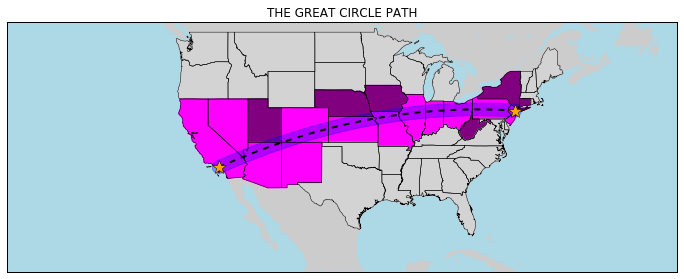

In [73]:
# Problem 1 solution:


# Create basemap instance like in class
m = Basemap(llcrnrlon=-150.,llcrnrlat=20.,
        urcrnrlon=-50.,urcrnrlat=50.,
        rsphere=(6378137.00,6356752.3142),
        resolution='l',projection='merc',
        lat_0=40.,lon_0=-100.,lat_ts=20.)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
states = m.readshapefile('../materials_Mason/states_21basic/states', 'states')
m.fillcontinents(lake_color='lightblue');
m.drawmapboundary(fill_color='lightblue')


# Determine great circle path and turn into polygon/dilated polygon

LAX_lat= 33.9425
LAX_lon= -118.4081
EWR_lat= 40.6925
EWR_lon= -74.1686
x_lax,y_lax = m(LAX_lon,LAX_lat)
x_EWR,y_EWR = m(EWR_lon,EWR_lat)
x,y = m.gcpoints(LAX_lon,LAX_lat,EWR_lon,EWR_lat,500)
xs = np.array(x)
ys = np.array(y)
xy = zip(xs,ys)
line = shapely.geometry.LineString(xy)
dilated = line.buffer(100000)


# fill polygons intersecting both lines. 

polys = []
names = []
for state in enumerate(m.states):
    poly = shapely.geometry.Polygon(state[1])
    name = m.states_info[state[0]]['STATE_NAME']
    if poly.intersects(dilated):
        color = 'purple'
        names.append(name)
        n='States on great circle path'
    else:
        color = 'lightgray'
    if poly.intersects(line):
        color = 'magenta'
        n = 'States within 100 km'
    ax.fill(*poly.boundary.xy, color=color)

    

# plot results
ax.set_title('THE GREAT CIRCLE PATH')
m.set_axes_limits()
state_list = np.sort(np.unique(names))
ax.fill(*dilated.boundary.xy,alpha=0.3,color='b')
ax.plot(xs,ys,'--k',lw=2)
ax.plot(x_EWR,y_EWR,'*',ms=15,color='orange')
ax.plot(x_lax,y_lax,'*',ms=15,color='orange')


# Print names

print("The states within 100km of the great circle from LAX to EWR are: ",'\n','\n')
for i in state_list:
    print(i)

### 2. Area in a Voronoi diagram

Given the series of points:

     np.array([[ 0.77354201,  0.34072038],
               [ 0.43807549,  0.93001924],
               [ 0.5624092 ,  0.79438991],
               [ 0.02536295,  0.46180244],
               [ 0.59533179,  0.07522803],
               [ 0.47867418,  0.70302822],
               [ 0.30371564,  0.83135442],
               [ 0.5856915 ,  0.16340903],
               [ 0.14700491,  0.60268997],
               [ 0.97098631,  0.51692456]])
               
create a Voronoi diagram, and calculate the area contained in the finite regions. What fraction of the total area is at least 0.001 unit away from any boundary? 0.01 away? And 0.1 away?


98.9 % of the total area is at least 0.001 units away from the boundary
89.34 % of the total area is at least 0.01 units away from the boundary
23.57 % of the total area is at least 0.1 units away from the boundary


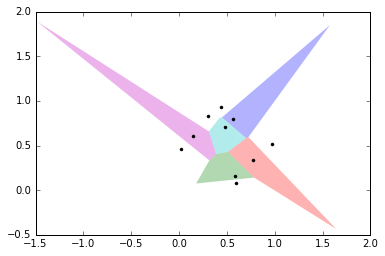

In [34]:
# Problem 2 solution


# create points and voronoi polygon vertices

pts = np.array([[ 0.77354201,  0.34072038],
                [ 0.43807549,  0.93001924],
                [ 0.5624092 ,  0.79438991],
                [ 0.02536295,  0.46180244],
                [ 0.59533179,  0.07522803],
                [ 0.47867418,  0.70302822],
                [ 0.30371564,  0.83135442],
                [ 0.5856915 ,  0.16340903],
                [ 0.14700491,  0.60268997],
                [ 0.97098631,  0.51692456]])

vor = spatial.Voronoi(pts)
polys=[]


# Create polygons
for indices in vor.regions:
    if not indices: continue     # check for empty regions
    if -1 in indices: continue   # region includes a vertex out of the diagram (the region goes to infinity)
    plt.fill(vor.vertices[indices, 0], vor.vertices[indices, 1], edgecolor='none', alpha=0.3)
    line = shapely.geometry.LineString(zip(vor.vertices[indices,0],vor.vertices[indices,1]))
    closed_line = shapely.geometry.LinearRing(line)
    polys.append(shapely.geometry.Polygon(closed_line))


new_pol = shapely.ops.cascaded_union(polys) 

pol_001 = new_pol.buffer(-0.001).area/new_pol.area*100
print(round(pol_001,2),'% of the total area is at least 0.001 units away from the boundary')

pol_01 = new_pol.buffer(-0.01).area/new_pol.area*100
print(round(pol_01,2),'% of the total area is at least 0.01 units away from the boundary')

pol_1 = new_pol.buffer(-0.1).area/new_pol.area*100
print(round(pol_1,2),'% of the total area is at least 0.1 units away from the boundary')



plt.plot(pts[:, 0], pts[:, 1], '.k')

### 3. 2D interpolation

Data (found in `python4geosciences/data/MS03_L15.txt`) gathered from a field cruise out of the TAMU Oceanography department is randomly located in space (that is, unstructured) because of the nature of the measurement: the instrument is lowered into the water from a ship, and is brought up and down through the water column as the ship moves to get a sampling of the fields.

Read in the data file and plot the temperature in a `scatter` plot as a function of depth and latitude. Next, interpolate the temperature data to be on a uniform grid (to make it structured). Now, plot it using `contourf`, which requires structured data. Experiment with different spacing in your uniform grid, and with different numbers of contours to see how the results change, and choose values that provide a nice-looking image which closely resembles the original data.

/Users/emilymason/anaconda/lib/python3.5/site-packages/pandas/io/parsers.py:1572: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/emilymason/anaconda/lib/python3.5/site-packages/pandas/io/parsers.py:1574: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


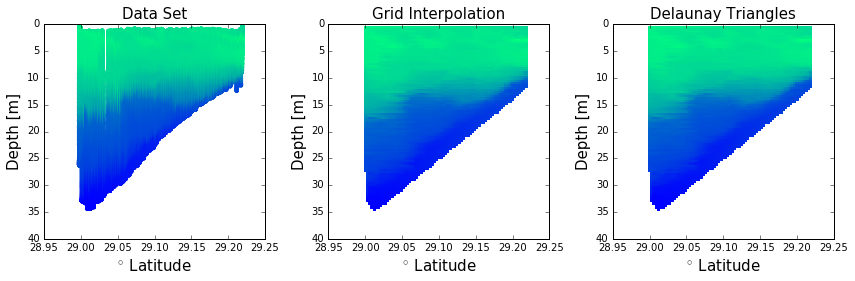

In [55]:
# Problem 3 solution

# read in and plot data

name=['latitude','longitude','Depth','Temperature', 'density00','sigma-t00','sbeox0ML/L','v2','v3','v3','wetCDOM','flECO-AFL','upoly0','prdM','sal00','RINKO Temperature' ,'RINKO DO, based on CTD Temp','RINKO DO, based on RINKO Temp' ,'bottom depth','PAR'] 
df = pd.read_table('../data_Mason/MS03_L15.txt', comment='*', skiprows=[115] , index_col=0,sep=r"\s*",engine='python',header=None,names=name)
lat=df.index
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(131)
ax.scatter(df.index,df['Depth'],c=df['Temperature'],cmap='winter',lw=0)
ax.set_ylim(40,0)
ax.set_xlabel('$^{\circ}$ Latitude',fontsize=15)
ax.set_ylabel('Depth [m]',fontsize=15)
ax.set_title('Data Set',fontsize=15)

# Create interpolation instance and plot
interp = interpolate.LinearNDInterpolator((df.index,df['Depth']),df['Temperature'])
ygrid, xgrid = np.meshgrid(np.linspace(0,40,100), np.linspace(28.95,29.25,100))
zgrid = interp(xgrid, ygrid)
zgrid = np.ma.masked_where(np.isnan(zgrid), zgrid)
ax2 = fig.add_subplot(132)
ax2.pcolor(xgrid,ygrid,zgrid,cmap='winter',lw=0)
ax2.set_ylim(40,0)
ax2.set_xlabel('$^{\circ}$ Latitude',fontsize=15)
ax2.set_ylabel('Depth [m]',fontsize=15)
ax2.set_title('Grid Interpolation',fontsize=15)

# Create interpolation instance and plot using triangles

gridpoints = np.transpose(np.vstack((df.index,df['Depth'])))
tri = spatial.Delaunay(gridpoints)
interp = interpolate.LinearNDInterpolator(tri,df['Temperature'])
ygrid, xgrid = np.meshgrid(np.linspace(0,40,100), np.linspace(28.95,29.25,100))
zgrid = interp(xgrid, ygrid)
zgrid = np.ma.masked_where(np.isnan(zgrid), zgrid)
ax3 = fig.add_subplot(133)
ax3.pcolormesh(xgrid,ygrid,zgrid,cmap='winter',lw=0)
ax3.set_ylim(40,0)
ax3.set_xlabel('$^{\circ}$ Latitude ',fontsize=15)
ax3.set_ylabel('Depth [m]',fontsize=15)
ax3.set_title('Delaunay Triangles',fontsize=15)
fig.tight_layout()

### 4. (Grad) Area of Greenland and Australia in different projections

Set up Basemap instances of the following projections: Mercator, Robinson, and Mollweide; make sure that all three projections are set up to show both Greenland and Australia at the same time (this is necessary for Mercator in particular). Plot them side-by-side to see how they compare.

Next, read in the shape files for Greenland and Australia, found in the `data` directory; you can do this with something like the following (but you might need to change the directory path):

> m.readshapefile('../python4geosciences/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
> m.readshapefile('../python4geosciences/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)

where `m` is a `Basemap` instance. This gives you a series of polygons that make up each country, saved in `m.greenland` and `m.australia`. Find the area of the two countries in each projection and compare them. What is the area of Australia relative to the area of Greenland for each projection, and how does this compare to what it is in reality?

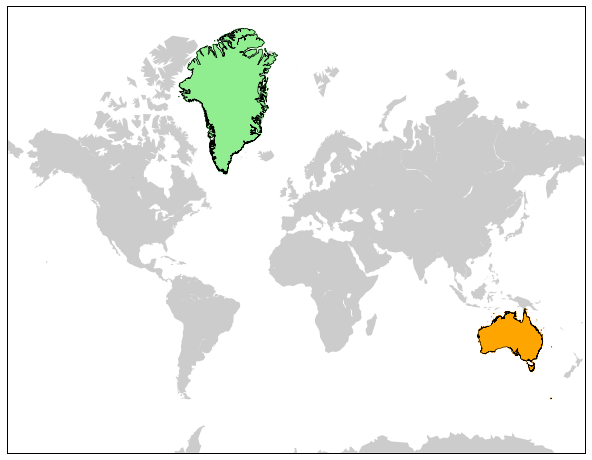

In [5]:
# Problem 4 solution:

# Mercator projection
m = Basemap(llcrnrlon=-180.,llcrnrlat=-70.,
        urcrnrlon=180.,urcrnrlat=85.,
        rsphere=(6378137.00,6356752.3142),
        resolution='c',projection='merc',
        lat_0=0.,lon_0=0.,lat_ts=20.);
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
greenland = m.readshapefile('../data_Mason/GRL_adm_shp/GRL_adm0', 'greenland'); 
australia = m.readshapefile('../data_Mason/AUS_adm_shp/AUS_adm0', 'australia');
m.fillcontinents();
poly_green=0
for poly in m.greenland:
    poly_green+=shapely.geometry.Polygon(poly).area/1000**2
    ax.fill(*shapely.geometry.Polygon(poly).boundary.xy,color='lightgreen')
poly_ausie=0
for poly in m.australia:
    poly_ausie+=shapely.geometry.Polygon(poly).area/1000**2
    ax.fill(*shapely.geometry.Polygon(poly).boundary.xy,color='orange')

    
    
merc_proj=poly_ausie/poly_green

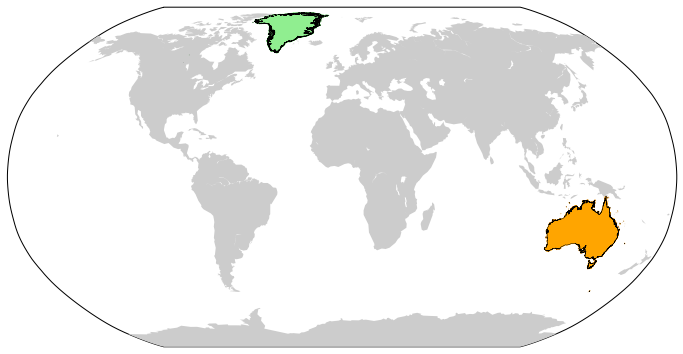

In [6]:
# Robinson Projection
m2 = Basemap(llcrnrlon=-180.,llcrnrlat=-80.,
        urcrnrlon=180.,urcrnrlat=80.,
        rsphere=(6378137.00,6356752.3142),
        resolution='c',projection='robin',
        lat_0=40.,lon_0=0.,lat_ts=20.)
fig2 = plt.figure(figsize=(12,8))
ax2 = fig2.add_subplot(111)
green2 = m2.readshapefile('../data_Mason/GRL_adm_shp/GRL_adm0', 'greenland'); 
ausie2 = m2.readshapefile('../data_Mason/AUS_adm_shp/AUS_adm0', 'australia');
m2.fillcontinents();

polyr_green=0
for poly in m2.greenland:
    polyr_green+=shapely.geometry.Polygon(poly).area/1000**2
    ax2.fill(*shapely.geometry.Polygon(poly).boundary.xy,color='lightgreen')
polyr_ausie=0
for poly in m2.australia:
    polyr_ausie+=shapely.geometry.Polygon(poly).area/1000**2
    ax2.fill(*shapely.geometry.Polygon(poly).boundary.xy,color='orange')
robin_proj=polyr_ausie/polyr_green

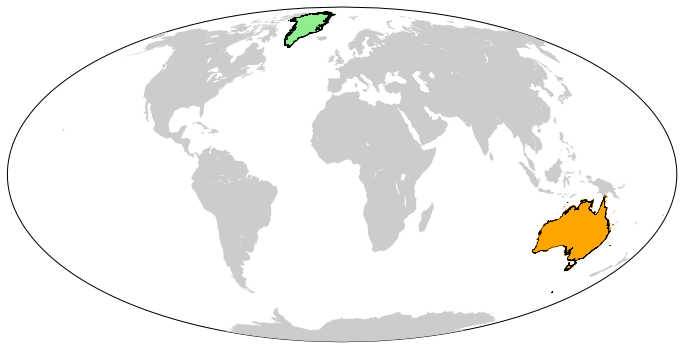

In [7]:
# Mollweide projection

m3 = Basemap(llcrnrlon=-200.,llcrnrlat=20.,
        urcrnrlon=0.,urcrnrlat=80.,
        rsphere=(6378137.00,6356752.3142),
        resolution='c',projection='moll',
        lat_0=0.,lon_0=0.,lat_ts=20.)
fig3 = plt.figure(figsize=(12,8))
ax3 = fig3.add_subplot(111)
green3 = m3.readshapefile('../data_Mason/GRL_adm_shp/GRL_adm0', 'greenland'); 
ausie3 = m3.readshapefile('../data_Mason/AUS_adm_shp/AUS_adm0', 'australia');
m3.fillcontinents();


polym_green=0
for poly in m3.greenland:
    polym_green+=shapely.geometry.Polygon(poly).area/1000**2
    ax3.fill(*shapely.geometry.Polygon(poly).boundary.xy,color='lightgreen')
polym_ausie=0
for poly in m3.australia:
    polym_ausie+=shapely.geometry.Polygon(poly).area/1000**2
    ax3.fill(*shapely.geometry.Polygon(poly).boundary.xy,color='orange')

moll_proj=polym_ausie/polym_green

In [8]:
gren = 2166086.0 #km
aus = 7682300.0 #km

print('The actual area ratio of Australia to Greenland is: ',round(aus/gren,2))
print('The area ratios for Mercator, Robinson, and Mollweide are respectively: ', round(merc_proj,2),', ',round(robin_proj,2),', ',round(moll_proj,2))

The actual area ratio of Australia to Greenland is:  3.55
The area ratios for Mercator, Robinson, and Mollweide are respectively:  0.27 ,  1.98 ,  3.61
